## Data preparation

For tuning the ML models and augmentation parameters, we need to split the train set into a train set and validation set. If we were to use temporal info later, we need to separate storms instead of images.



In [ ]:
from separate_val_data import separate_val_files 

In [ ]:
train_dir = 'data/train'
val_dir = 'data/val' 
# val dictionary should not exist, otherwise, it would raise error to avoid runnig it multiple times.
val_fr = 0.2

separate_val_files(train_dir, val_dir, val_fr)

## Directory structure

```
project
|____data
|    |____train
|    |     |___abc_001.jpg
|    |     |___abc_002.jpg
|    |
|    |____val
|    |     |___acc_001.jpg
|    |     |___acc_002.jpg
|    |
|    |____training_set_features.csv
|    |____training_set_labels.csv
|____separate_val_data.py
|____image_batch_gen.py
|____Hurricane.ipynb
```

## Make batch

In [2]:
import os
from os.path import join
import pandas as pd
import cv2
import numpy as np
#from tqdm import tqdm
import matplotlib.pyplot as plt
#import tensorflow as tf
import random

In [3]:
####   macOS fine-tune   ####
import sys 
sys.path.append("/Users/heather/tensorflow_macos_venv/lib/python3.8/site-packages/")
import tensorflow as tf
#from tensorflow.python.compiler.mlcompute import mlcompute

tf.compat.v1.disable_eager_execution()
print(tf.__version__)  # it says 2.4.0-rc0
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name = 'gpu')
#### macOS fine-tune end ####

2.4.0-rc0


In [ ]:
class ImgBatchGen(tf.keras.utils.Sequence):
    def __init__(self, img_dir, ground_truth_file, batch_size=32, img_size=None):
        self.bacth_size = batch_size
        files = os.listdir(img_dir)
        label_df = pd.read_csv(ground_truth_file, index_col=0, header=0)
        self.files = [(join(img_dir, f), label_df.loc[f[:7], 'wind_speed']) for f in files if f.endswith('.jpg')]
        random.shuffle(self.files)
        self.img_size=img_size
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.bacth_size))

    def __getitem__(self, index):
        images, labels = [], []

        for file, label in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
            img = cv2.imread(file, 0)
            if img is None:
                continue
            if self.img_size is not None:
                img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
            images.append(img)
            labels.append(label)

        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(labels).astype(np.float32)

        return x, y
    

In [3]:
class ImgBatchGenOneShot(tf.keras.utils.Sequence):
    def __init__(self, img_dir, ground_truth_file, batch_size=32, img_size=None):
        self.bacth_size = batch_size
        self.img_size=img_size
        files = os.listdir(img_dir)
        label_df = pd.read_csv(ground_truth_file, index_col=0, header=0)
        self.files = [(join(img_dir, f), label_df.loc[f[:7], 'wind_speed']) for f in files if f.endswith('.jpg')]
        random.shuffle(self.files)
        
        images, labels = [], []
        for file, label in self.files:
            img = cv2.imread(file, 0)
            if img is None:
                continue
            if self.img_size is not None:
                img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
            images.append(img)
            labels.append(label)
        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(labels).astype(np.float32)
            
        self.x = x
        self.y = y
        print('x shape', self.x.shape)
        print('y shape', self.y.shape)
        
        #
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.bacth_size))

    def __getitem__(self, index):
        images, labels = [], []
        
        x_batch = self.x[index*self.bacth_size:(index+1)*self.bacth_size, :, :]
        y_batch = self.y[index*self.bacth_size:(index+1)*self.bacth_size]

#         for file, label in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
#             img = cv2.imread(file, 0)
#             if img is None:
#                 continue
#             if self.img_size is not None:
#                 img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
#             images.append(img)
#             labels.append(label)

#         x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
#         y = np.array(labels).astype(np.float32)

        return x_batch, y_batch

In [4]:
img_size = 64
train_batchgen = ImgBatchGenOneShot('data/train', 'data/training_set_labels.csv', 32, img_size=img_size)
val_batchgen = ImgBatchGenOneShot('data/val', 'data/training_set_labels.csv', 32, img_size=img_size)

x shape (56739, 64, 64, 1)
y shape (56739,)
x shape (13518, 64, 64, 1)
y shape (13518,)


(32, 64, 64, 1) (32,)
43.0


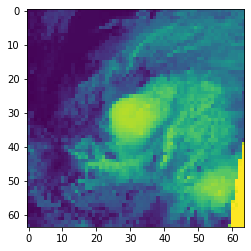

In [5]:
train_x, train_y = train_batchgen[0]
print(train_x.shape, train_y.shape)
plt.imshow(train_x[2])
print(train_y[2])

## Make Model

In [5]:
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

In [7]:
model = Sequential()
model.add(Conv2D(64, (7,7), padding='same', activation='relu', input_shape=(img_size, img_size, 1)))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Flatten())
#model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [8]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        3

In [ ]:
## Train

In [9]:
history = model.fit(train_batchgen, epochs = 50, verbose=1, validation_data=val_batchgen)

Epoch 1/50
1773/1773 [==============================] - 135s 74ms/step - batch: 886.0000 - size: 32.0000 - loss: 509.4578 - mse: 509.4584 - mae: 16.5918 - mape: 35.6327 - val_loss: 290.3282 - val_mse: 290.3282 - val_mae: 12.4331 - val_mape: 27.2163
Epoch 2/50
1773/1773 [==============================] - 132s 75ms/step - batch: 886.0000 - size: 32.0000 - loss: 352.5714 - mse: 352.5714 - mae: 13.6016 - mape: 28.8293 - val_loss: 333.0428 - val_mse: 333.0428 - val_mae: 12.7842 - val_mape: 24.2307
Epoch 3/50
1773/1773 [==============================] - 133s 75ms/step - batch: 886.0000 - size: 32.0000 - loss: 233.6745 - mse: 233.6745 - mae: 11.1092 - mape: 23.7515 - val_loss: 162.8826 - val_mse: 162.8826 - val_mae: 9.2592 - val_mape: 20.7641
Epoch 4/50
1773/1773 [==============================] - 132s 74ms/step - batch: 886.0000 - size: 32.0000 - loss: 157.5158 - mse: 157.5157 - mae: 9.3083 - mape: 20.1974 - val_loss: 149.7482 - val_mse: 149.7482 - val_mae: 9.0900 - val_mape: 21.9346
Epoch 5

In [10]:
model.save('jan23')



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: jan23/assets


In [11]:
ground_truth = []
pred = []
i = 0
for x_batch, y_batch in val_batchgen:
    pred.append(model.predict(x_batch).ravel())
    ground_truth.append(y_batch)
pred = np.hstack(pred)
ground_truth = np.hstack(ground_truth)

Text(0, 0.5, 'Prediction')

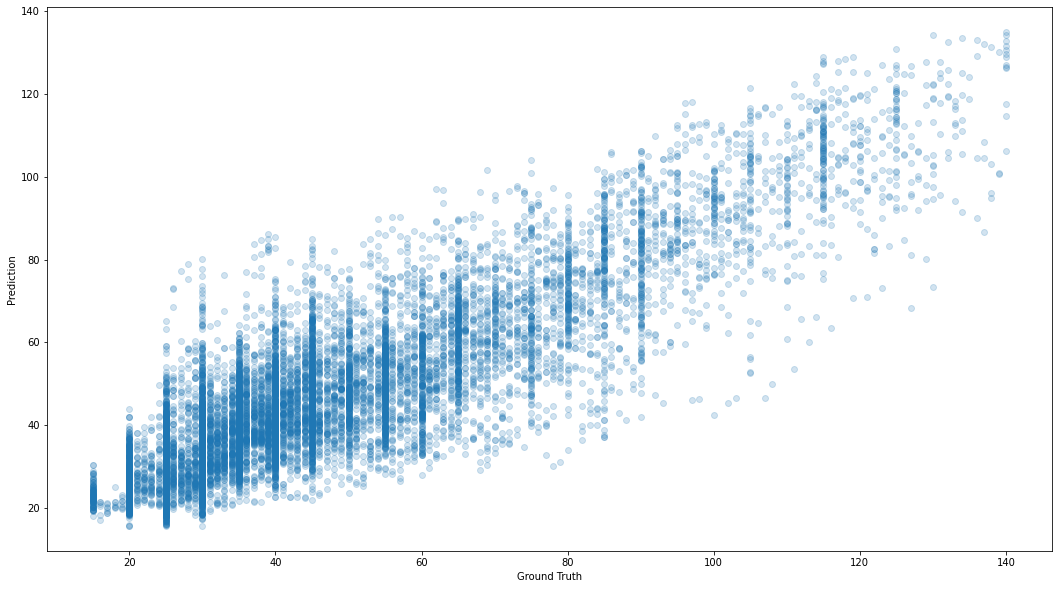

In [12]:
plt.figure(figsize=(18, 10))
plt.scatter(ground_truth, pred, alpha=0.2)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')

In [ ]:
#Start Predictions for Submission

In [4]:
class ImgBatchGenTestOneShot(tf.keras.utils.Sequence):
    def __init__(self, img_dir, batch_size=32, img_size=None):
        self.bacth_size = batch_size
        self.img_size=img_size
        files = os.listdir(img_dir)
        #label_df = pd.read_csv(ground_truth_file, index_col=0, header=0)
        #self.files = [(join(img_dir, f), label_df.loc[f[:7], 'wind_speed']) for f in files if f.endswith('.jpg')]

        self.files = [(join(img_dir, f)) for f in files if f.endswith('.jpg')]
        #random.shuffle(self.files)
        
        images, filenames = [], []
        for file in self.files:
            img = cv2.imread(file, 0)
            if img is None:
                continue
            if self.img_size is not None:
                img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
            images.append(img)
            filenames.append(file)
        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(filenames)
            
        self.x = x
        self.y = y
        print('x shape', self.x.shape)
        print('y shape', self.y.shape)
        
        #
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.bacth_size))

    def __getitem__(self, index):
        images, filenames = [], []
        
        x_batch = self.x
        y_batch = self.y

#         for file, label in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
#             img = cv2.imread(file, 0)
#             if img is None:
#                 continue
#             if self.img_size is not None:
#                 img = cv2.resize(img,(self.img_size, self.img_size), interpolation = cv2.INTER_CUBIC)
#             images.append(img)
#             labels.append(label)

#         x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
#         y = np.array(labels).astype(np.float32)

        return x_batch, y_batch

In [5]:
img_size = 64
test_batchgen = ImgBatchGenTestOneShot('data/test', 32, img_size=img_size)
#test_images, test_filenames = test_batchgen[0]
#test_images, test_filenames = ImageBatchGenTestOneShot
#train_batchgen = ImgBatchGenOneShot('data/train', 'data/training_set_labels.csv', 32, img_size=img_size)




x shape (44377, 64, 64, 1)
y shape (44377,)


(44377, 64, 64, 1) (44377,)
data/test/fkd_152.jpg


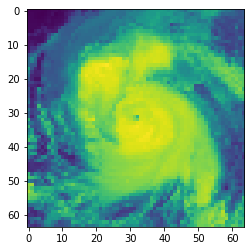

In [6]:
test_im, test_fname = test_batchgen[0]
print(test_im.shape, test_fname.shape)
plt.imshow(test_im[4])
print(test_fname[4])


In [9]:
test_batchgen.x

array([[[[0.05490196],
         [0.05490196],
         [0.05490196],
         ...,
         [0.48235294],
         [0.45490196],
         [0.47843137]],

        [[0.0627451 ],
         [0.0627451 ],
         [0.04313726],
         ...,
         [0.5764706 ],
         [0.5568628 ],
         [0.49411765]],

        [[0.04705882],
         [0.04313726],
         [0.07058824],
         ...,
         [0.6784314 ],
         [0.65882355],
         [0.6313726 ]],

        ...,

        [[0.08627451],
         [0.03529412],
         [0.08627451],
         ...,
         [0.16862746],
         [0.42745098],
         [0.45882353]],

        [[0.03137255],
         [0.04705882],
         [0.05882353],
         ...,
         [0.42352942],
         [0.5137255 ],
         [0.38431373]],

        [[0.03921569],
         [0.03921569],
         [0.05098039],
         ...,
         [0.24705882],
         [0.58431375],
         [0.5372549 ]]],


       [[[0.05882353],
         [0.08627451],
         [0.07

In [12]:
print(test_batchgen.x.shape)

(44377, 64, 64, 1)


In [13]:
from tensorflow import keras
model = keras.models.load_model('jan23')

In [14]:
predictions = model.predict(test_batchgen.x)

In [16]:
predictions.shape

(44377, 1)

In [17]:
predictions[4]. #this projected windspeed looks reasonable based on the image

array([98.74886], dtype=float32)

In [20]:
submission_df = pd.DataFrame({"Co1":test_batchgen.y, "Col2":predictions[:, 0]})
submission_df.head(10)

,Co1,Col2
0,data/test/rzf_038.jpg,50.759827
1,data/test/blt_426.jpg,36.394478
2,data/test/cqv_265.jpg,27.112795
3,data/test/buc_026.jpg,42.097389
4,data/test/fkd_152.jpg,98.748863
5,data/test/iiz_443.jpg,54.353973
6,data/test/hgj_197.jpg,28.868221
7,data/test/omv_078.jpg,88.872421
8,data/test/ugb_201.jpg,23.104328
9,data/test/tnn_214.jpg,26.507168


In [52]:

submission_df = pd.DataFrame({"image_id":test_fname, "wind_speed":predictions[:, 0]})
print(submission_df.head())
print(submission_df.dtypes)


                image_id  wind_speed
0  data/test/rzf_038.jpg   50.759827
1  data/test/blt_426.jpg   36.394478
2  data/test/cqv_265.jpg   27.112795
3  data/test/buc_026.jpg   42.097389
4  data/test/fkd_152.jpg   98.748863
image_id       object
wind_speed    float32
dtype: object


In [53]:
#format the data to match the submission file format 
submission_df['image_id'] = submission_df.astype(str)
submission_df['image_id'] = submission_df['image_id'].str.slice(start=10, stop=17)
submission_df['wind_speed'] = submission_df['wind_speed'].round(0).astype(int)
submission_df = submission_df.sort_values(['image_id'])
submission_df.head() 

,image_id,wind_speed
29084,acd_123,35
23310,acd_124,31
23366,acd_125,30
26234,acd_126,30
26094,acd_127,31


In [54]:
submission_df.to_csv("submission1.csv", index=False)